# Variations in Material Properties
In real-world applications, materials often have varying thermal properties due to factors such as composition, temperature, or phase changes. To model such scenarios, we can modify the finite difference equations to account for spatially varying thermal properties.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mtrl-ubc/mtrl361/blob/main/transient-heat-transfer/varying_material_properties.ipynb)

## Multimaterial Domain
In a multimaterial domain, the thermal properties such as thermal conductivity, density, and specific heat capacity can vary spatially. This requires modifying the finite difference equations to account for the different material properties at each node. The thermal diffusivity $\alpha$ will be different for each material, leading to different Fourier numbers for each segment of the domain.
```{exercise}
:label: implicit_multimaterial
```{figure} multimaterial.png
:label: multimaterial
:alt: Multimaterial Domain
:align: center
Representation of a rod composed of two materials with different thermal properties.

Implement the implicit finite difference method to solve the 1D transient heat conduction equation in a rod composed of two materials with different thermal properties. The left half of the rod is made of material A, and the right half is made of material B. The thermal properties are as follows:
| Material | Thermal Conductivity (W/m·K) | Density (kg/m³) | Specific Heat Capacity (J/kg·K) |
|----------|------------------------------|------------------|----------------------------------|
| A        | 200                          | 2700             | 900                              |
| B        | 50                           | 7800             | 500                              |

The boundary conditions and simulation parameters are:
| Boundary Condition | Simulation Parameter |
|--------------------|----------------------|
| $T(0, t) = 300 °C$ | Length of the rod, $L: 0.1 m$ |
| $T(L, t) = 2000 °C$ | Time step, $\Delta t: 0.1 s$ |
| Initial temperature, $T(x, 0) = 25 °C$ | Spatial step, $\Delta x: 0.01 m$ |
```

Using the implicit method, we can set up the system of equations to solve for the temperatures at the next time step, taking into account the different material properties at each node.

The middle nodes at the interface between the two materials will require special treatment to account for the discontinuity in thermal properties. The two nodes will exist at the same location but will be subject to a gap heat transfer coefficient or contact resistance. This can be modeled by introducing an interface heat transfer coefficient, $h_{interface} = 2000 W/m^2K$, which represents the effective thermal conductivity at the interface between the two materials.

### Construct the matrix equation

Assuming we have six nodes and node 2 and 3 are on the solid/solid interface

$$\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
-F_o & 1+2F_o & -F_o & 0 & 0 & 0\\
0 &-2F_o & 1+ 2 F_o + 2F_o B_i  & -2F_o B_i & 0 & 0\\
0 & 0 &-2F_o B_i & 1+ 2 F_o + 2F_o B_i  & -2F_o & 0 \\
0 & 0 & 0 &-F_o & 1+2F_o & -F_o \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
T_0^{t+\Delta t} \\T_1^{t+\Delta t}  \\ T_2^{t+\Delta t}  \\T_3^{t+\Delta t} \\T_4^{t+\Delta t}\\T_5^{t+\Delta t}
\end{pmatrix} =
\begin{pmatrix} T_0^{t} \\T_1^{t}  \\ T_2^{t}  \\T_3^{t} \\T_4^{t}\\T_5^{t} + 2F_o B_i T_{amb} \end{pmatrix}$$

In [34]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Material properties for Material A
k_A = 200.0       # W/m·C
rho_A = 2700.0    # kg/m³
c_pA = 900.0      # J/kg·C
alpha_A = k_A / (rho_A * c_pA)  # m^2/s

# Material properties for Material B
k_B = 50.0        # W/m·C
rho_B = 7800.0    # kg/m³
c_pB = 500.0      # J/kg·C
alpha_B = k_B / (rho_B * c_pB)  # m^2/s

# gap heat transfer coefficient at the interface
h_interface = 2000.0 # W/m^2·K

# Simulation parameters
time_final = 40 # s
L = 0.1         # m
dt = 0.1       # s
dx = 0.01       # m
T_init = 25.0   # °C
T_L = 300.0     # °C
T_R = 2000.0      # °C
num_node = int(L/dx) + 1
num_ts = int(time_final/dt) + 1    # total time steps

# Additional parameters
L_half = L / 2   # Length of each half
num_node_A = num_node // 2  # Number of nodes for Material A
num_node_B = num_node - num_node_A  # Number of nodes for Material B

# Create spatial grid
x_A = np.arange(num_node_A)*dx
x_B = np.arange(num_node_B)*dx + x_A[-1]
x_vector = np.append(x_A, x_B)

# Calculate Fourier numbers and Biot number at the interface
Fo_A = alpha_A * dt / dx**2
Fo_B = alpha_B * dt / dx**2
Bi_A = h_interface * dx / k_A
Bi_B = h_interface * dx / k_B

# Initialize temperature array for implicit method with multimaterial domain
T_multimaterial = np.zeros((num_node, num_ts)) # T[i, n]
# Set initial condition
T_multimaterial[:, 0] = T_init
# Set boundary conditions
T_multimaterial[0, :] = T_L
T_multimaterial[-1, :] = T_R

```{note} Conditional Statements
Note the use of `if`, `elif`, and `else` statements to handle the different regions of the multimaterial domain. This allows us to apply the appropriate finite difference equations based on the location of each node.
```

In [36]:
# Implicit method solver with multimaterial domain
# Set up the coefficient matrix A and right-hand side vector b
A = np.zeros((num_node, num_node)) # Coefficient matrix
b = np.zeros(num_node)              # Right-hand side vector
# Fill the coefficient matrix A; including gap conductivity at the interface
for i in range(1, num_node - 1):
    if i < num_node_A - 1:  # Material A
        A[i, i - 1] = -Fo_A
        A[i, i] = 1 + 2 * Fo_A
        A[i, i + 1] = -Fo_A
    elif i == num_node_A - 1:  # Interface node for Material A
        A[i, i - 1] = -2 * Fo_A
        A[i, i] = 1 + 2 * Fo_A + 2 * Fo_A * Bi_A
        A[i, i + 1] = -2 * Fo_A * Bi_A
    elif i == num_node_A:  # Interface node for Material B
        A[i, i - 1] = -2 * Fo_B * Bi_B
        A[i, i] = 1 + 2 * Fo_B + 2 * Fo_B * Bi_B
        A[i, i + 1] = -2 * Fo_B
    else:  # Material B
        A[i, i - 1] = -Fo_B
        A[i, i] = 1 + 2 * Fo_B
        A[i, i + 1] = -Fo_B
    A[0, 0] = 1
    A[-1, -1] = 1
# Implicit method solver
for n in range(num_ts - 1):
    # Fill the right-hand side vector b
    for i in range(1, num_node - 1):
        b[i] = T_multimaterial[i, n]
    # Apply boundary conditions in vector b
    b[0] = T_L
    b[-1] = T_R
    # Solve the linear system A * T_new = b
    T_new = np.linalg.solve(A, b)
    # Update the temperature array for the next time step
    T_multimaterial[:, n + 1] = T_new

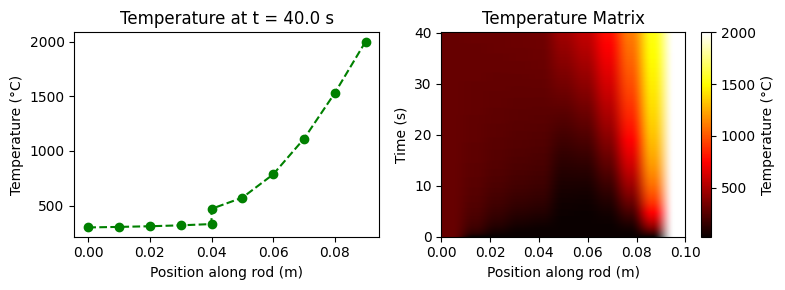

In [37]:
# Plot final temperature distribution for implicit method with multimaterial domain
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(x_vector, T_multimaterial[:, -1],
            'go--', label='Implicit Method with Multimaterial Domain')
ax[0].set_xlabel('Position along rod (m)')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title('Temperature at t = {:.1f} s'.format(time_final))

im1 = ax[1].imshow(T_multimaterial.T, aspect='auto', cmap='hot',
            extent=[0, L, 0, dt*num_ts], origin='lower')
fig.colorbar(im1, ax=ax[1], label='Temperature (°C)')
ax[1].set_ylabel('Time (s)')
ax[1].set_xlabel('Position along rod (m)')
ax[1].set_title('Temperature Matrix')
plt.tight_layout()
plt.show()

## Latent Heat Generation during Phase Change
Applying latent heat generation during phase change would require modifying the heat equation to account for the latent heat term. This can be done by introducing an additional source term in the finite difference equations that represents the energy absorbed or released during the phase change. The implementation would depend on the specific phase change material properties and the conditions under which the phase change occurs. The effective heat capacity method or enthalpy method can be used to incorporate latent heat into the numerical scheme.

$C_{eff} = C_p + {L}\frac{df_s}{dT}$
$C_{eff} = C_p + {L}\frac{1}{T_{solidus}-T_{liquidus}}$

Incorporating the latent heat into the numerical implementation would involve adjusting the source term in the finite difference scheme accordingly.

````{exercise} Latent Heat Phase Change
:label: implicit_phase_change
Implement the implicit finite difference method to solve the 1D transient heat conduction equation in a rod of length $L = 0.1 m$, initially at a uniform temperature of $2000 °C$, above the melting point of steel. The left end of the bar is suddenly cooled to $25 °C$, while the right end is insulated. The material properties of steel are as follows:
| Property | Value |
|----------|-------|
| Thermal Conductivity, $k$ | 45 $W/m·K$ |
| Density, $ρ$ | 7850 $kg/m³$ |
| Specific Heat Capacity, $c_p$ | 500 $J/kg°C$ |
| Latent Heat of Fusion, $L$ | 272000 $J/kg$ | |
| Solidus Temperature, $T_{solidus}$ | 1450 $°C$ |
| Liquidus Temperature, $T_{liquidus}$ | 1550 $°C$ |

In [38]:
# Material properties and simulation parameters for phase change
time_final = 200 # s
k = 45.0         # W/m·K
rho = 7850.0     # kg/m^3
c_p = 500.0      # J/kg·K
L = 272000.0    # J/kg
T_solidus = 1450.0  # °C
T_liquidus = 1550.0 # °C
alpha = k / (rho * c_p)  # m^2/s
L_bar = 0.1         # m
dt = 1.0            # s
dx = 0.001          # m
T_init = 2000.0     # °C
T_L = 25.0          # °C
num_node = int(L_bar/dx) + 1
num_ts = int(time_final/dt) + 1    # total time steps

# Calculate Fourier number
Fo = alpha * dt / dx**2
print("Fourier number (Fo):", Fo)

Fourier number (Fo): 11.464968152866243


In [39]:
# Initialize temperature array for implicit method with phase change
T_phase_change = np.zeros((num_node, num_ts)) # T[i, n]
# Set initial condition
T_phase_change[:, 0] = T_init
# Set left boundary condition (cooled)
T_phase_change[0, :] = T_L

```{warning} Approximation Note
The implementation below uses an effective heat capacity approach to account for latent heat during phase change. This is a simplified method and may not capture all the complexities of phase change phenomena. More sophisticated methods that accurately predict the temperature distribution during phase change may be required for precise applications.
```

In [40]:
# Implicit method solver with phase change
for n in range(num_ts - 1):
    # Set up the coefficient matrix A and right-hand side vector b
    A = np.zeros((num_node, num_node)) # Coefficient matrix
    b = np.zeros(num_node)              # Right-hand side vector
    # Fill the coefficient matrix A
    for i in range(1, num_node - 1):
        # Determine effective heat capacity based on temperature
        T_current = T_phase_change[i, n]
        if T_current < T_solidus or T_current > T_liquidus:
            c_p_eff = c_p
        else:
            c_p_eff = c_p + L / (T_liquidus - T_solidus)
        alpha_eff = k / (rho * c_p_eff)
        Fo_eff = alpha_eff * dt / dx**2
        A[i, i - 1] = -Fo_eff
        A[i, i] = 1 + 2 * Fo_eff
        A[i, i + 1] = -Fo_eff
    # Apply boundary conditions in matrix A
    A[0, 0] = 1
    A[-1, -2] = -2*Fo
    A[-1, -1] = 1 + 2*Fo  # Insulated boundary


    # Fill the right-hand side vector b
    for i in range(1, num_node - 1):
        b[i] = T_phase_change[i, n]
    # Apply boundary conditions in vector b
    b[0] = T_L
    b[-1] = T_phase_change[-2, n]  # Insulated boundary
    # Solve the linear system A * T_new = b
    T_new = np.linalg.solve(A, b)
    # Update the temperature array for the next time step
    T_phase_change[:, n + 1] = T_new

```{tip} Zip function
The `zip` function is used to iterate over multiple sequences (like lists or arrays) in parallel. In the plotting section, it pairs each axis object with a corresponding time index to plot temperature distributions at specific time steps.
```

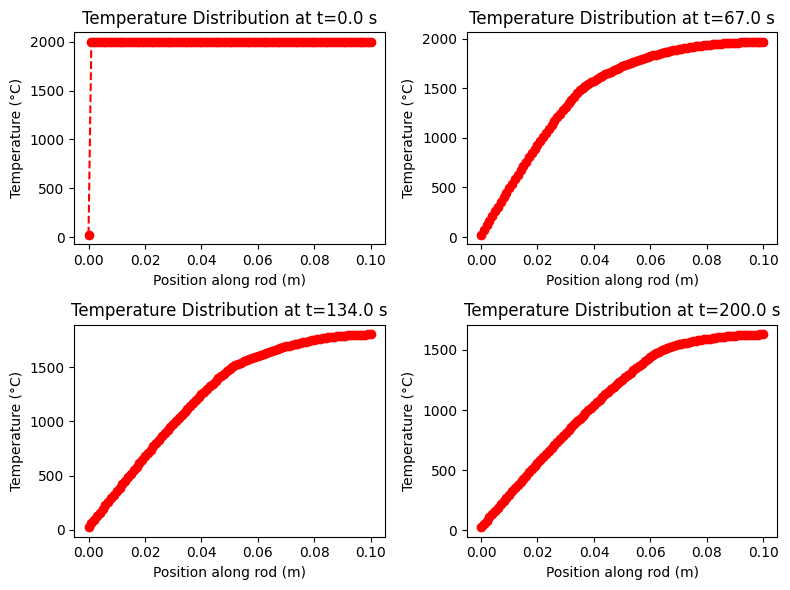

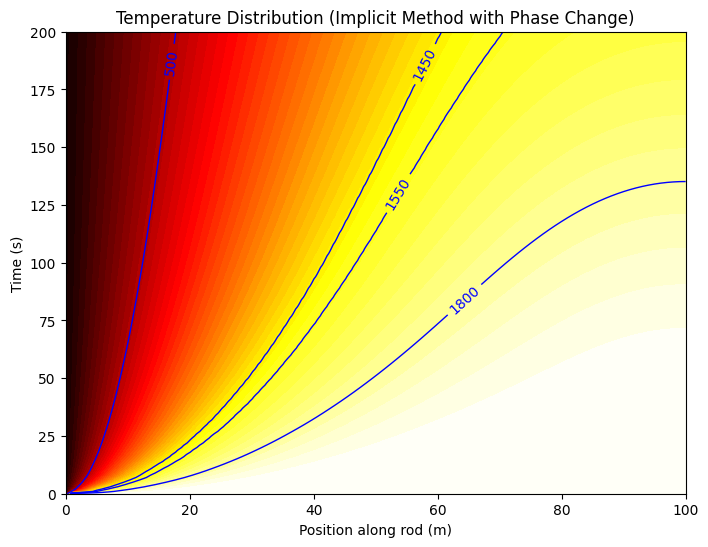

In [41]:
# Plot 4 plots evenly spaced in time for implicit method with phase change
time_steps = np.linspace(0, time_final, num_ts)
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
time_indices = [0, num_ts//3, 2*num_ts//3, num_ts - 1]
for ax, idx in zip(axs.flatten(), time_indices):
    ax.plot(np.linspace(0, L_bar, num_node), T_phase_change[:, idx], 'ro--')
    ax.set_xlabel('Position along rod (m)')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'Temperature Distribution at t={time_steps[idx]:.1f} s')
plt.tight_layout()
plt.show()

# Visualize the matrix after computation for implicit method with phase change
fig, ax = plt.subplots(figsize=(8, 6))
ax.contourf((T_phase_change.T), levels=50, cmap='hot')
cs=ax.contour((T_phase_change.T), levels=[500, T_solidus, T_liquidus, 1800], colors='blue', linewidths=1)
ax.clabel(cs, cs.levels, fontsize=10)
ax.set_ylabel('Time (s)')
ax.set_xlabel('Position along rod (m)')
ax.set_title('Temperature Distribution (Implicit Method with Phase Change)')
plt.show()

- The contour lines indicate the phase change regions, with the area between T_solidus and T_liquidus representing the mushy zone where the material is partially solid and partially liquid.
- The temperature distribution plot shows how the temperature evolves over time, with the left end of the bar cooling down rapidly due to the boundary condition, while the right end remains insulated. The phase change occurs as the temperature drops below the liquidus temperature, leading to a plateau in the temperature profile due to the latent heat absorption during solidification.

```{exercise} Reducing mushy zone interval
:label: reduce_mushy_zone
Modify the previous implementation to reduce the mushy zone interval by changing the solidus and liquidus temperatures to $T_{solidus} = 1480 °C$ and $T_{liquidus} = 1500 °C$. Observe and discuss how this change affects the temperature distribution and phase change behavior in the rod.
```